In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

## 3 Visualize Regularization Contours

x.shape: (2, 100), "y.shape:" (1, 100)


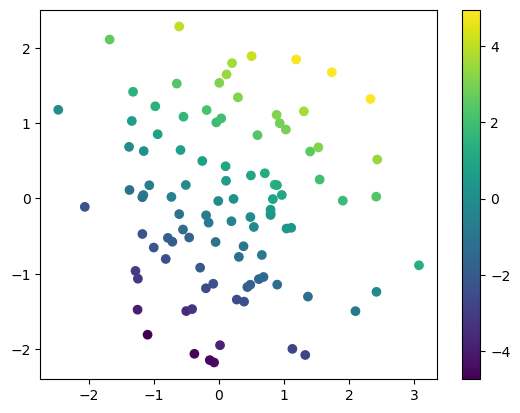

In [2]:
# load the data
data = np.load('data/linreg.npz')
x = data['X']
y = data['Y']
print(f'x.shape: {x.shape}, "y.shape:" {y.shape}')
plt.scatter(*x, c=y); 
plt.colorbar()
plt.show()

In [3]:
# create a grid of points in the parameter space
b1, b2 = np.linspace(-1, 3, 101), np.linspace(-1, 3, 101)
bs = np.stack(np.meshgrid(b1, b2, indexing='ij'), axis=-1)
bs.shape

(101, 101, 2)

### (a)

Text(0.5, 1.0, 'Loss of Rigde regularization term')

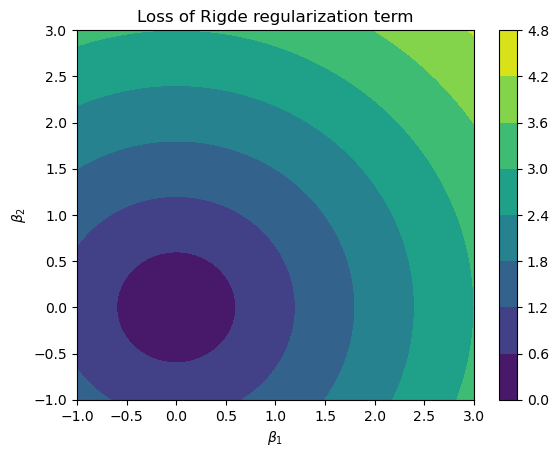

In [4]:
ridge = np.zeros((len(b1), len(b2)))
lasso = np.zeros((len(b1), len(b2)))

for i in range(len(b1)):
    for j in range(len(b2)):
        ridge[i][j] = np.linalg.norm([b1[i],b2[j]], ord=2)
        lasso[i][j] = np.linalg.norm([b1[i],b2[j]], ord=1)

plt.contourf(b1, b2, ridge)
plt.colorbar()
plt.xlabel(r"$\beta_1$")
plt.ylabel(r"$\beta_2$")
plt.title("Loss of Rigde regularization term")

Text(0.5, 1.0, 'Loss of Lasso regularization term')

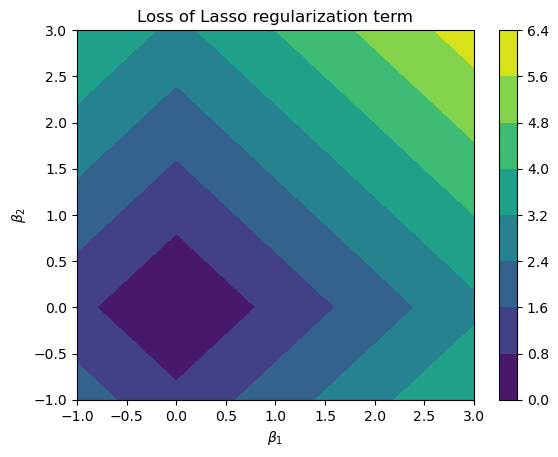

In [5]:
plt.contourf(b1, b2, lasso)
plt.colorbar()
plt.xlabel(r"$\beta_1$")
plt.ylabel(r"$\beta_2$")
plt.title("Loss of Lasso regularization term")

### (b)

Text(0.5, 1.0, 'Sum of Squares SSQ')

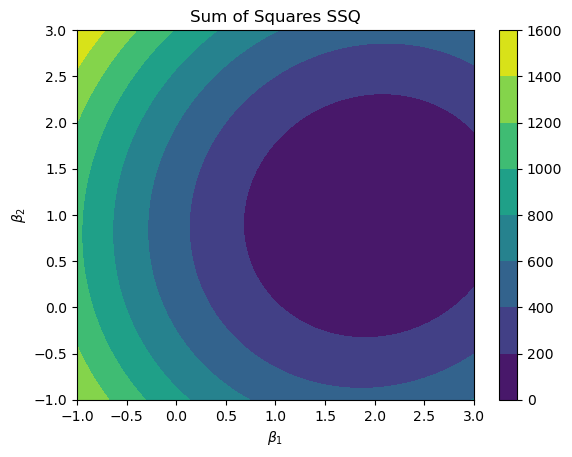

In [6]:
SSQ = np.zeros((len(b1), len(b2)))

for i, b1_i in enumerate(b1):
    for j, b2_j in enumerate(b2):
        step = y - x.T @ np.array([b1_i, b2_j])
        SSQ[i][j] = (step[0]).T @ (step[0]) 

plt.contourf(b1, b2, SSQ)
plt.colorbar()
plt.xlabel(r"$\beta_1$")
plt.ylabel(r"$\beta_2$")
plt.title("Sum of Squares SSQ")
    

### (c)

In [7]:
def ridge_loss(l):
    loss = np.zeros((len(b1), len(b2)))

    for i, b1_i in enumerate(b1):
        for j, b2_j in enumerate(b2):
            step = y - x.T @ np.array([b1_i, b2_j])
            loss[i][j] = (step[0]).T @ (step[0]) + l * np.linalg.norm([b1_i,b2_j], ord=2) 
    return loss

def lasso_loss(l):
    loss = np.zeros((len(b1), len(b2)))

    for i, b1_i in enumerate(b1):
        for j, b2_j in enumerate(b2):
            step = y - x.T @ np.array([b1_i, b2_j])
            loss[i][j] = (step[0]).T @ (step[0]) + l * np.linalg.norm([b1_i,b2_j], ord=1)
    return loss
    

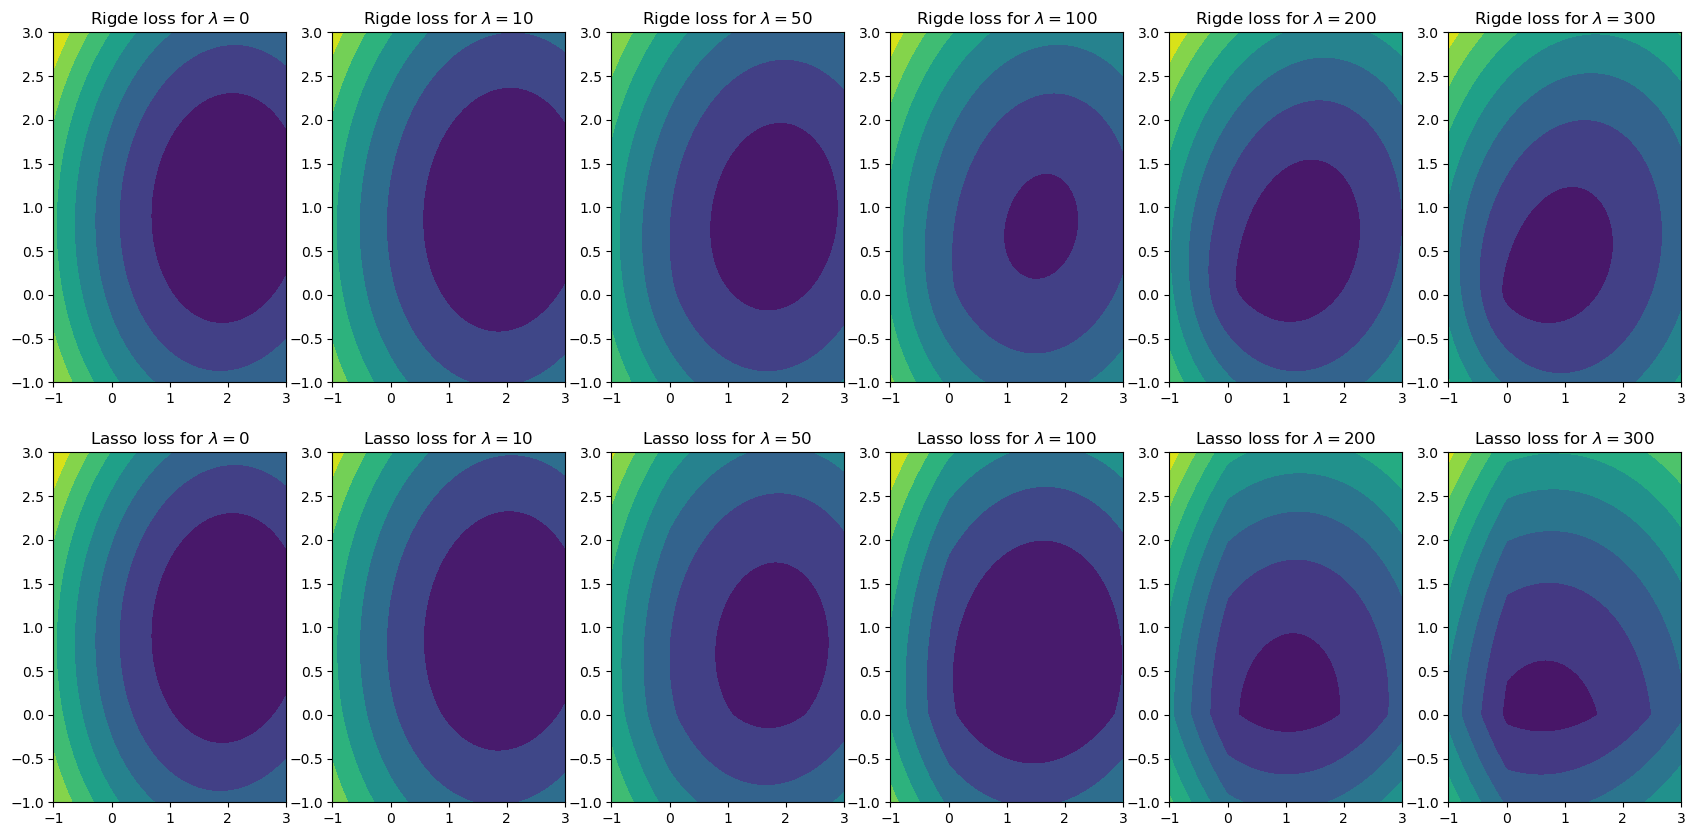

In [8]:
# TODO: for each lambda, plot both ridge regression and lasso loss functions
lambdas = [0, 10, 50, 100, 200, 300]

fig, axs = plt.subplots(2, 6, figsize = (21, 10))

for i, l in enumerate(lambdas):
    axs[0][i].contourf(b1, b2, ridge_loss(l))
    axs[1][i].contourf(b1, b2, lasso_loss(l))
    axs[0][i].set_title(f"Rigde loss for $\lambda = {l}$")
    axs[1][i].set_title(f"Lasso loss for $\lambda = {l}$")

## 4 CT Reconstruction

First, set up the design matrix. (Run this once to save it to the disk)

In [9]:
# create design matrix
# don't change any of this, just run it once to create and save the design matrix
import os

n_parallel_rays = 70 
n_ray_angles = 30
res = (99, 117)
print("Number of pixels in the 2d image:", np.prod(res))
print("Total number of rays:", n_parallel_rays * n_ray_angles)

def rot_mat(angle):
    c, s = np.cos(angle), np.sin(angle)
    return np.stack([np.stack([c, s], axis=-1), np.stack([-s, c], axis=-1)], axis=-1)

kernel = lambda x: np.exp(-x**2/sigma**2/2)

if not os.path.exists('data/design_matrix.npy'):
    xs = np.arange(0, res[1]+1) - res[1]/2 # np.linspace(-1, 1, res[1] + 1)
    ys = np.arange(0, res[0]+1) - res[0]/2 # np.linspace(-1, 1, res[0] + 1)

    # rays are defined by origin and direction
    ray_offset_range = [-res[1]/1.5, res[1]/1.5]
    n_rays = n_parallel_rays * n_ray_angles

    ray_angles = np.linspace(0, np.pi, n_ray_angles, endpoint=False) + np.pi/n_ray_angles

    # offsets for ray_angle = 0, i.e. parallel to x-axis
    ray_0_offsets = np.stack([np.zeros(n_parallel_rays), np.linspace(*ray_offset_range, n_parallel_rays)], axis=-1)
    ray_0_directions = np.stack([np.ones(n_parallel_rays), np.zeros(n_parallel_rays)], axis=-1)

    

    ray_rot_mats = rot_mat(ray_angles)

    ray_offsets = np.einsum('oi,aij->aoj', ray_0_offsets, ray_rot_mats).reshape(-1, 2)
    ray_directions = np.einsum('oi,aij->aoj', ray_0_directions, ray_rot_mats).reshape(-1, 2)

    sigma = 1
    xsc = (xs[1:] + xs[:-1]) / 2
    ysc = (ys[1:] + ys[:-1]) / 2
    b = np.stack(np.meshgrid(xsc, ysc), axis=-1).reshape(-1, 2)
    a = ray_offsets
    v = ray_directions
    v = v / np.linalg.norm(v, axis=-1, keepdims=True)
    p = ((b[None] - a[:, None]) * v[:, None]).sum(-1, keepdims=True) * v[:, None] + a[:, None]
    d = np.linalg.norm(b - p, axis=-1)
    d = kernel(d)
    design_matrix = d.T

    np.save('data/design_matrix.npy', design_matrix)
    print(f'created and saved design matrix of shape {design_matrix.shape} at data/design_matrix.npy')

Number of pixels in the 2d image: 11583
Total number of rays: 2100


sino shape: (1, 2100)


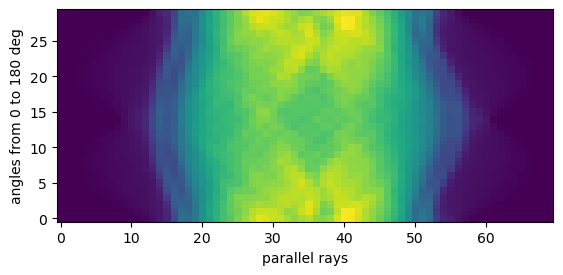

In [10]:
sino = np.load('data/sino.npy')

print(f'sino shape: {sino.shape}')

# visualize sinogram as image
n_parallel_rays = 70
n_angles = 30
plt.imshow(sino.reshape(n_angles, n_parallel_rays), origin='lower')
# plt.colorbar()
plt.xlabel('parallel rays')
plt.ylabel('angles from 0 to 180 deg')
plt.show();

### (a)

Each column in the design matrix $X$ represents the contribution of a single pixel in the image to a specific measurement in $Y$, which is a detector readout at a specific angle. So each column corresponds to the contribution of one pixel to a particular detector readout along a certain angle.

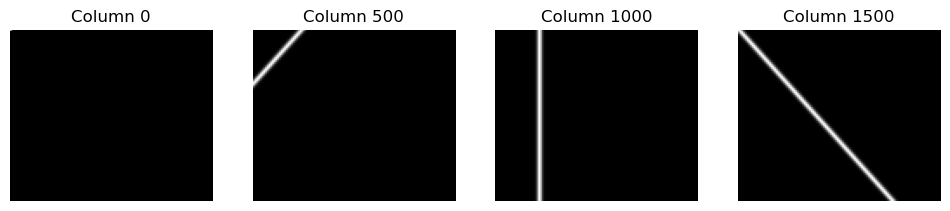

In [26]:
design_matrix = np.load('data/design_matrix.npy')

# TODO: visualize four random columns as images, using an image shape of (99, 117)

# Visualizing four columns reshaped to the image size
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i, col_idx in enumerate([0, 500, 1000, 1500]):  # Choose 4 columns
    column_image = design_matrix[:, col_idx].reshape((99, 117))
    axes[i].imshow(column_image, cmap="gray")
    axes[i].set_title(f'Column {col_idx}')
    axes[i].axis('off')
plt.show()

### (b)

Each row in $X$ represents the contribution of all image pixels to a particular measurement in the sinogram $Y$. This means a row encodes the weights for all pixels contributing to a single detector reading at a certain angle.

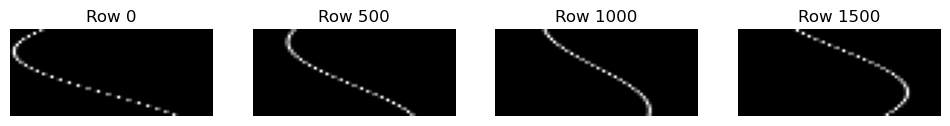

In [27]:
# TODO: visualize four random rows as images, using an images

fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i, row_idx in enumerate([0, 500, 1000, 1500]):  # Choose 4 rows
    row_image = design_matrix[row_idx, :].reshape(30, 70)
    axes[i].imshow(row_image, cmap='gray')
    axes[i].set_title(f'Row {row_idx}')
    axes[i].axis('off')
plt.show()

### (c)

In [ ]:
# TODO: solve the reconstruction with linear regression and visualize the result

In [ ]:
# TODO: solve the reconstruction with ridge regression and visualize the result
# Optional: try out different regularization strengths and oberve the influence
from sklearn.linear_model import Ridge


## 5 Bonus: X-Ray Free-Electron Lasers

In [ ]:
sino = np.load('data/sino.npy').reshape(n_angles, n_parallel_rays)
plt.imshow(sino)
plt.title('original sinogram')
plt.show()

order = np.arange(n_angles)
np.random.shuffle(order)
sino_shuffled = sino[order]
plt.imshow(sino_shuffled)
plt.title('shuffled sinogram')
plt.show()